## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Sun May 22 16:59:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:08:00.0 Off |                  N/A |
| 23%   20C    P8    10W / 250W |   3355MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.sqrt(total_loss / len(train_dataset))
        val_loss = np.sqrt(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 7839.69680972558 val_loss: 848.6387390654211
epoch 1 train_loss: 559.6928519611389 val_loss: 455.9192543687736
epoch 2 train_loss: 402.6658069112753 val_loss: 391.3730031788226
epoch 3 train_loss: 373.34373338502866 val_loss: 373.1222157764338
epoch 4 train_loss: 365.6943083887512 val_loss: 363.86626309302943
epoch 5 train_loss: 362.2230592031487 val_loss: 362.1643317429992
epoch 6 train_loss: 359.5005305884475 val_loss: 364.11925033394107
epoch 7 train_loss: 357.2439221714963 val_loss: 362.03972710087004
epoch 8 train_loss: 355.0830238354271 val_loss: 354.9028322893973
epoch 9 train_loss: 353.64531919668894 val_loss: 348.8382791148539
epoch 10 train_loss: 351.94197161388536 val_loss: 346.8217536379209
epoch 11 train_loss: 349.7700810070846 val_loss: 347.976099106762
epoch 12 train_loss: 347.3242273058757 val_loss: 351.2397561149182
epoch 13 train_loss: 344.95534391068304 val_loss: 353.48726246727426
epoch 14 train_loss: 342.3611758424019 val_loss: 354.

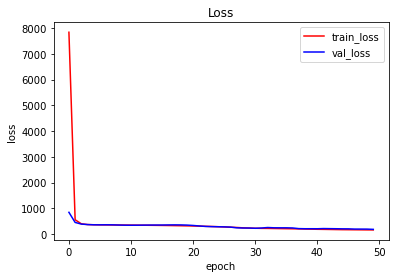

city: miami
epoch 0 train_loss: 17258.503095237873 val_loss: 1965.3162707720123
epoch 1 train_loss: 837.1709304027697 val_loss: 459.3370683451997
epoch 2 train_loss: 406.550488854165 val_loss: 379.9739877191666
epoch 3 train_loss: 362.1722565415831 val_loss: 346.46094409202396
epoch 4 train_loss: 344.8309779020828 val_loss: 336.3270245032538
epoch 5 train_loss: 335.61403573769735 val_loss: 329.96914582614403
epoch 6 train_loss: 333.5471277538583 val_loss: 327.4124807239875
epoch 7 train_loss: 334.10850902955053 val_loss: 331.6872743070743
epoch 8 train_loss: 332.2613829133644 val_loss: 339.2661562229905
epoch 9 train_loss: 330.57862308189675 val_loss: 339.84893894610644
epoch 10 train_loss: 329.0134267640023 val_loss: 324.31763752929555
epoch 11 train_loss: 327.8937629623028 val_loss: 314.8953024668142
epoch 12 train_loss: 327.8698163678623 val_loss: 315.0409368034231
epoch 13 train_loss: 325.2245640239333 val_loss: 311.18572975762424
epoch 14 train_loss: 319.7235454768346 val_loss: 30

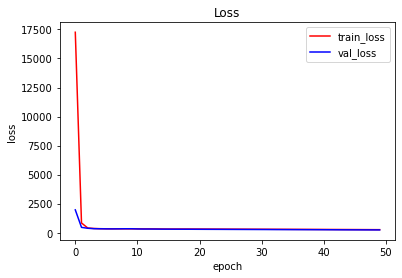

city: pittsburgh
epoch 0 train_loss: 15060.943700726217 val_loss: 1594.1687088751444
epoch 1 train_loss: 642.1559551276604 val_loss: 367.85749841855636
epoch 2 train_loss: 340.7634510257613 val_loss: 325.6455326506549
epoch 3 train_loss: 321.9653712394491 val_loss: 317.08577798905
epoch 4 train_loss: 317.59378382456623 val_loss: 317.3094043984914
epoch 5 train_loss: 316.4506610589154 val_loss: 326.3304454190953
epoch 6 train_loss: 316.49737103153075 val_loss: 335.69186681413566
epoch 7 train_loss: 316.8366337080316 val_loss: 317.8446241782889
epoch 8 train_loss: 316.07153735605607 val_loss: 309.7862165753277
epoch 9 train_loss: 315.96275771045276 val_loss: 316.20440523177854
epoch 10 train_loss: 315.75431848239066 val_loss: 332.0784977150519
epoch 11 train_loss: 315.8170316795337 val_loss: 343.28644096928014
epoch 12 train_loss: 316.3494656881326 val_loss: 343.8854474068476
epoch 13 train_loss: 317.7258366788179 val_loss: 340.1688911345992
epoch 14 train_loss: 319.2667715128343 val_los

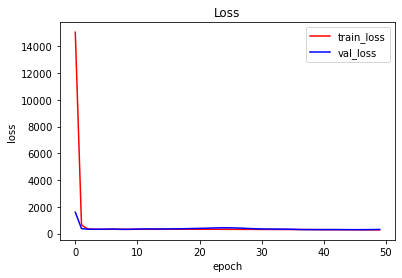

city: dearborn
epoch 0 train_loss: 40099.372694407386 val_loss: 7938.888383474813
epoch 1 train_loss: 3528.2711887586815 val_loss: 1221.9886627279052
epoch 2 train_loss: 896.3954865312731 val_loss: 591.7118733163676
epoch 3 train_loss: 555.0262052053273 val_loss: 498.93797495173766
epoch 4 train_loss: 495.8134629504642 val_loss: 488.5360836992751
epoch 5 train_loss: 483.2480149230617 val_loss: 499.8480586672914
epoch 6 train_loss: 477.5560019566531 val_loss: 521.8270496669126
epoch 7 train_loss: 474.4973387613155 val_loss: 527.131735791129
epoch 8 train_loss: 471.97584710078894 val_loss: 525.780749421243
epoch 9 train_loss: 469.92139696871936 val_loss: 518.5474047525397
epoch 10 train_loss: 468.00039450730503 val_loss: 505.46788048631964
epoch 11 train_loss: 466.1281278829289 val_loss: 491.37613004019187
epoch 12 train_loss: 464.922274125411 val_loss: 479.45290652031673
epoch 13 train_loss: 464.84105416149464 val_loss: 468.737211728988
epoch 14 train_loss: 465.2613376977342 val_loss: 4

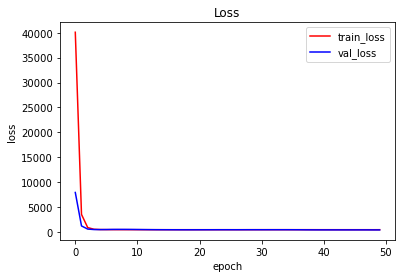

city: washington-dc
epoch 0 train_loss: 22438.89869996934 val_loss: 5519.804877903236
epoch 1 train_loss: 5440.0393942424025 val_loss: 5375.5248887257685
epoch 2 train_loss: 4735.3814968372535 val_loss: 2424.5042323877683
epoch 3 train_loss: 1174.6587021893017 val_loss: 568.7614246106832
epoch 4 train_loss: 484.1830198414534 val_loss: 401.5869550138656
epoch 5 train_loss: 395.33316251456637 val_loss: 363.8841852253405
epoch 6 train_loss: 369.52692094266297 val_loss: 351.26010238009127
epoch 7 train_loss: 359.82567769985127 val_loss: 343.6570330239204
epoch 8 train_loss: 354.48174729469287 val_loss: 339.27041689908685
epoch 9 train_loss: 350.99781633079266 val_loss: 336.002718973661
epoch 10 train_loss: 348.2061291357882 val_loss: 332.65692101123625
epoch 11 train_loss: 346.1244975059586 val_loss: 330.019777001496
epoch 12 train_loss: 344.9991058957304 val_loss: 328.4720541788599
epoch 13 train_loss: 344.5474839340065 val_loss: 328.07212523606114
epoch 14 train_loss: 344.42677426354334 

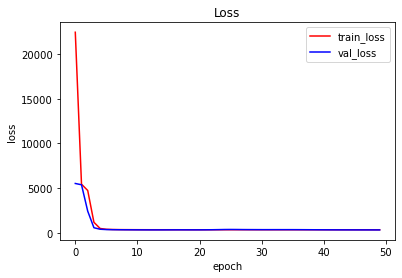

city: palo-alto
epoch 0 train_loss: 14294.697814751027 val_loss: 8698.791156801255
epoch 1 train_loss: 7514.13430643118 val_loss: 4585.919335101912
epoch 2 train_loss: 2725.007935860156 val_loss: 833.5633402111586
epoch 3 train_loss: 650.7188688171371 val_loss: 546.9820945653513
epoch 4 train_loss: 520.9690685557775 val_loss: 489.03667000936383
epoch 5 train_loss: 481.6899664130321 val_loss: 466.55940585397946
epoch 6 train_loss: 463.6205086603057 val_loss: 454.53487834095273
epoch 7 train_loss: 453.80639933024474 val_loss: 446.2328451144703
epoch 8 train_loss: 447.56124259137204 val_loss: 441.43846778131245
epoch 9 train_loss: 443.50204354493513 val_loss: 439.8453008048608
epoch 10 train_loss: 440.26139971212666 val_loss: 439.252146070805
epoch 11 train_loss: 437.198152953516 val_loss: 437.2472200400497
epoch 12 train_loss: 434.09284323543085 val_loss: 432.7507386601461
epoch 13 train_loss: 431.4753746152047 val_loss: 428.6513363469392
epoch 14 train_loss: 429.6568545140968 val_loss: 

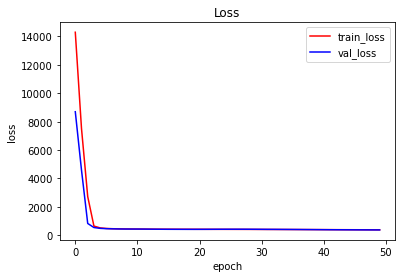

CPU times: user 5min 24s, sys: 10.8 s, total: 5min 35s
Wall time: 5min 35s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=2e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
    pickle.dump(pred, open('models/mlp_3_layer_' + city + '_large', 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/mlp_3_layer_' + city + '_large', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-32.266319,-555.015320,-33.053665,-558.148499,-33.776669,-557.908752,-33.440060,-557.823975,-32.562988,...,-34.690357,-556.427429,-33.242981,-556.657593,-33.969826,-555.091003,-36.336506,-555.700623,-36.235958,-557.561401
1,1_austin,-345.463745,-14.977170,-342.567535,-17.271513,-345.064789,-17.361160,-342.874969,-14.620408,-345.127167,...,-344.291138,-18.639862,-343.766266,-17.114939,-342.035980,-15.835904,-343.273895,-19.249542,-342.593933,-19.616226
2,2_austin,52.628616,-247.880249,52.638718,-247.863968,52.831501,-247.715897,52.372562,-248.278305,52.709679,...,52.213821,-248.348526,53.006851,-248.767502,52.456993,-248.632751,52.575703,-248.093613,52.606812,-248.420151
3,3_austin,-107.983253,1797.288086,-103.797379,1795.160034,-107.183479,1797.006348,-106.478035,1796.692505,-104.727753,...,-93.685509,1791.187134,-93.476807,1791.497803,-92.168800,1790.630127,-92.486877,1788.817993,-93.945076,1789.971069
4,4_austin,1222.642700,-652.125732,1226.384033,-649.058899,1224.114502,-643.675354,1223.716553,-648.872925,1222.691895,...,1234.954224,-655.425354,1231.517334,-656.325684,1236.677368,-656.346802,1234.226929,-654.849548,1238.575439,-651.586365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1379.242554,-458.497650,-1373.053833,-457.643127,-1375.432007,-457.983154,-1387.881714,-452.446228,-1385.380005,...,-1385.345825,-455.449615,-1380.436646,-464.047516,-1377.669067,-455.344391,-1369.265869,-457.764526,-1373.377197,-455.407379
29839,1682_palo-alto,128.851624,-34.693630,130.213135,-35.267010,128.859329,-36.033703,127.691597,-33.854588,128.151566,...,129.366287,-34.011135,130.151108,-35.613373,129.872391,-34.107071,129.932480,-34.306683,130.697662,-33.967628
29840,1683_palo-alto,-1457.041138,2157.111084,-1450.582153,2155.419922,-1452.750732,2157.736816,-1449.292725,2156.516602,-1453.875244,...,-1446.044189,2166.343262,-1445.536987,2159.704834,-1447.503662,2160.108154,-1447.851074,2158.982178,-1445.065430,2161.372803
29841,1684_palo-alto,1042.732178,1379.555420,1041.298584,1382.399536,1052.199951,1383.840698,1058.892578,1378.404663,1063.887207,...,1060.344482,1385.940552,1055.368286,1373.765991,1042.971436,1378.060791,1048.060059,1373.412598,1043.392456,1377.724121


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-32.266320,-555.01530,-33.053665,-558.148500,-33.77667,-557.908750,-33.440060,-557.824000,-32.562990,...,-34.690357,-556.427400,-33.24298,-556.657600,-33.969826,-555.091000,-36.336506,-555.700600,-36.235960,-557.561400
1,1_austin,-345.463750,-14.97717,-342.567540,-17.271513,-345.06480,-17.361160,-342.874970,-14.620408,-345.127170,...,-344.291140,-18.639862,-343.76627,-17.114939,-342.035980,-15.835904,-343.273900,-19.249542,-342.593930,-19.616226
2,2_austin,52.628616,-247.88025,52.638718,-247.863970,52.83150,-247.715900,52.372562,-248.278300,52.709680,...,52.213820,-248.348530,53.00685,-248.767500,52.456993,-248.632750,52.575703,-248.093610,52.606810,-248.420150
3,3_austin,-107.983250,1797.28810,-103.797380,1795.160000,-107.18348,1797.006300,-106.478035,1796.692500,-104.727750,...,-93.685510,1791.187100,-93.47681,1791.497800,-92.168800,1790.630100,-92.486880,1788.818000,-93.945076,1789.971100
4,4_austin,1222.642700,-652.12573,1226.384000,-649.058900,1224.11450,-643.675350,1223.716600,-648.872900,1222.691900,...,1234.954200,-655.425350,1231.51730,-656.325700,1236.677400,-656.346800,1234.226900,-654.849550,1238.575400,-651.586360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1379.242600,-458.49765,-1373.053800,-457.643130,-1375.43200,-457.983150,-1387.881700,-452.446230,-1385.380000,...,-1385.345800,-455.449620,-1380.43660,-464.047520,-1377.669100,-455.344400,-1369.265900,-457.764530,-1373.377200,-455.407380
29839,1682_palo-alto,128.851620,-34.69363,130.213130,-35.267010,128.85933,-36.033703,127.691600,-33.854588,128.151570,...,129.366290,-34.011135,130.15111,-35.613373,129.872390,-34.107070,129.932480,-34.306683,130.697660,-33.967630
29840,1683_palo-alto,-1457.041100,2157.11100,-1450.582200,2155.420000,-1452.75070,2157.736800,-1449.292700,2156.516600,-1453.875200,...,-1446.044200,2166.343300,-1445.53700,2159.704800,-1447.503700,2160.108200,-1447.851100,2158.982200,-1445.065400,2161.372800
29841,1684_palo-alto,1042.732200,1379.55540,1041.298600,1382.399500,1052.20000,1383.840700,1058.892600,1378.404700,1063.887200,...,1060.344500,1385.940600,1055.36830,1373.766000,1042.971400,1378.060800,1048.060000,1373.412600,1043.392500,1377.724100
